In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the necessary libraries
!pip install transformers
!pip install scikit-learn
!pip install datasets evaluate
!pip install optuna
!pip install pandas

^C


In [ ]:
import re
import torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback)
from sklearn.preprocessing import LabelEncoder
import numpy as np
import optuna
from evaluate import load
import json
import pandas as pd
import optuna.visualization.matplotlib as optuna_viz
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Check that pyTorch is identifying the GPU
if torch.cuda.device_count() > 0:
  print(f'GPU detected. Currently using: "{torch.cuda.get_device_name(0)}"')
else:
  raise Exception('Currently using CPU, change the type of the runtime in the \'runtime\' tab')

GPU detected. Currently using: "Tesla T4"


# Prepare the data

In [ ]:
# Paths
train_data_path = '/content/drive/MyDrive/TFG/data/train_data.csv'
test_data_path = '/content/drive/MyDrive/TFG/data/test_data.csv'
valid_data_path = '/content/drive/MyDrive/TFG/data/validation_data.csv'
save_path = '/content/drive/MyDrive/TFG/models'

model_name = 'bert-base-uncased'
#model_name = 'roberta-base'

# Load datasets from CSV files using pandas and convert to Dataset
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
valid_df = pd.read_csv(valid_data_path)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
valid_dataset = Dataset.from_pandas(valid_df)

# Make sure they only contain the expected tags
valid_labels = ['add', 'remove', 'view', 'clear']
train_dataset = train_dataset.filter(lambda example: example["intent"] in valid_labels)
test_dataset = test_dataset.filter(lambda example: example["intent"] in valid_labels)
valid_dataset = valid_dataset.filter(lambda example: example["intent"] in valid_labels)

# Convert text labels to numeric indices
label_encoder = LabelEncoder()
label_encoder.fit(valid_labels)

train_labels = label_encoder.transform(train_dataset["intent"])
test_labels = label_encoder.transform(test_dataset["intent"])
valid_labels = label_encoder.transform(valid_dataset["intent"])

# Add labels as a new column in the datasets
train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
valid_dataset = valid_dataset.add_column("labels", valid_labels)

Filter:   0%|          | 0/1960 [00:00<?, ? examples/s]

Filter:   0%|          | 0/420 [00:00<?, ? examples/s]

Filter:   0%|          | 0/420 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/1960 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Flattening the indices:   0%|          | 0/420 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/420 [00:00<?, ? examples/s]

# Proceso de clasificación

## Tokenización


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Function to tokenize phrases
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

# Tokenize the datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)
valid_tokenized = valid_dataset.map(tokenize_function, batched=True)

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(valid_labels),
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

## Define metrics




In [ ]:
accuracy = load('accuracy')
precision = load('precision')
f1 = load('f1')
recall = load("recall")

# Function to compute metrics
def compute_metrics(eval_pred):
  predictions, labels = eval_pred

  predictions = np.argmax(predictions, axis=1)

  result_prec = precision.compute(predictions=predictions, references=labels, average='macro')["precision"]
  result_acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
  result_f1 = f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
  result_recall = recall.compute(predictions=predictions, references=labels, average='macro')["recall"]

  return {
        "accuracy": result_acc,
        "precision": result_prec,
        "f1-score": result_f1,
        "recall": result_recall
  }

In [ ]:
output_dir_final = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}"
os.makedirs(output_dir_final, exist_ok=True)

def objective(trial):
    # Optuna automatically selects values within these ranges to optimize

    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)  # 🔧 How much the model weights are adjusted at each step
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])  # 🔧 Number of samples processed in parallel per step
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2)  # 🔧 Regularization to avoid overfitting (penalizes large weights)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.1, 0.3)  # 🔧 Initial portion of training with increasing LR (warm-up)

    # Training configuration
    training_args = TrainingArguments(
        output_dir="results_bert",  # 📁 Folder where models and logs will be saved
        num_train_epochs=10,  # 🔁 Total number of full passes through the dataset
        per_device_train_batch_size=batch_size,  # ⛽ Batch size for training
        per_device_eval_batch_size=batch_size,  # ⛽ Batch size for evaluation
        warmup_ratio=warmup_ratio,  # 🔥 Portion of training with gradually increasing LR
        weight_decay=weight_decay,  # 📉 L2 regularization to avoid overfitting
        learning_rate=learning_rate,  # 🚀 Learning rate
        eval_strategy="epoch",  # 📊 Evaluate once per epoch
        save_strategy="epoch",  # 💾 Save model at the end of each epoch
        save_total_limit=2,  # 📦 Keep only the last 2 models (saves space)
        load_best_model_at_end=True,  # 🏅 Load best performing model on validation at the end
        metric_for_best_model="eval_loss",  # 🎯 Metric used to determine the best model
        greater_is_better=False,  # ✅ Lower is better (for eval loss)
        gradient_accumulation_steps=2,  # 🪄 Accumulate gradients to simulate a larger batch size
        fp16=True,  # ⚡ Use 16-bit precision training (faster and uses less memory)
        logging_dir=f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/logs",  # 📝 Directory to save training logs
        logging_steps=50,  # 📈 Log metrics every 50 steps
        lr_scheduler_type="cosine",  # 📉 Reduce LR following a cosine curve
        max_grad_norm=1.0  # 🚫 Max gradient norm (prevents exploding gradients)
    )

    # Trainer definition
    trainer = Trainer(
        model_init=model_init,  # 🔧 Function to initialize the model (define it outside)
        args=training_args,  # ⚙️ Arguments defined above
        train_dataset=train_tokenized,  # 📚 Training dataset (tokenized)
        eval_dataset=valid_tokenized,  # 📚 Validation dataset (tokenized)
        tokenizer=tokenizer,  # ✂️ Tokenizer to convert text into IDs
        compute_metrics=compute_metrics,  # 📏 Function to compute evaluation metrics
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # 🛑 Stop training if no improvement after 3 epochs
    )

    # Model training
    trainer.train()

    # Model evaluation
    eval_result = trainer.evaluate()

    # Return validation loss so Optuna can optimize it
    return eval_result["eval_loss"]

# Create an Optuna study to optimize hyperparameters
study = optuna.create_study(direction="minimize")  # 🔍 Optuna will try to minimize the metric (loss)
study.optimize(objective, n_trials=10)  # 🎲 Run 10 trials with different combinations of hyperparameters

# Retrieve the best hyperparameter configuration found by Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Save the best hyperparameters to a JSON file
params_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/{model_name.replace('/', '_')}_best_params_loss.json"
with open(params_path, "w") as f:
    json.dump(study.best_params, f, indent=4)
print(f"✅ Best hyperparameters saved to: {params_path}")


[I 2025-06-06 11:03:01,616] A new study created in memory with name: no-name-f3a69c4f-93fa-4fc6-aa7d-68ca54e1da74
<ipython-input-21-94c017c24bda>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


[W 2025-06-06 11:03:19,807] Trial 0 failed with parameters: {'learning_rate': 5.645044427860635e-06, 'batch_size': 16, 'weight_decay': 0.1974872937889157, 'warmup_ratio': 0.29227742435934534} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-21-94c017c24bda>", line 48, in objective
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2240, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2618, in _inner_training_loop
    model.zero_grad()
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 2904, in zero_grad
    for p in self.parameters():
  File "/usr/local/lib/python3.11/dist-package

KeyboardInterrupt: 

# Save the model

✅ Mejores hiperparámetros: {'learning_rate': 1.9564689242622504e-05, 'batch_size': 8, 'weight_decay': 0.17223494237252657, 'warmup_ratio': 0.14285160298820462}


<ipython-input-28-55916c968b07>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,F1-score,Recall
1,5.144500,3.680455,0.250000,0.062500,0.100000,0.250000
2,2.333500,1.066090,0.778571,0.796596,0.773779,0.778571
3,0.500600,0.173631,0.966667,0.969349,0.966342,0.966667
4,0.135300,0.061292,0.988095,0.988383,0.988070,0.988095
5,0.055100,0.040027,0.995238,0.995327,0.995238,0.995238
6,0.052000,0.037482,0.992857,0.993056,0.992856,0.992857
7,0.022700,0.037949,0.995238,0.995327,0.995238,0.995238
8,0.007400,0.038377,0.995238,0.995327,0.995238,0.995238
9,0.023500,0.045301,0.992857,0.993056,0.992856,0.992857


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Resultados en test:: {'eval_loss': 0.05419369786977768, 'eval_accuracy': 0.9904761904761905, 'eval_precision': 0.9905206821480407, 'eval_f1-score': 0.9904759745118936, 'eval_recall': 0.9904761904761905, 'eval_runtime': 0.8175, 'eval_samples_per_second': 513.774, 'eval_steps_per_second': 64.833, 'epoch': 9.0}


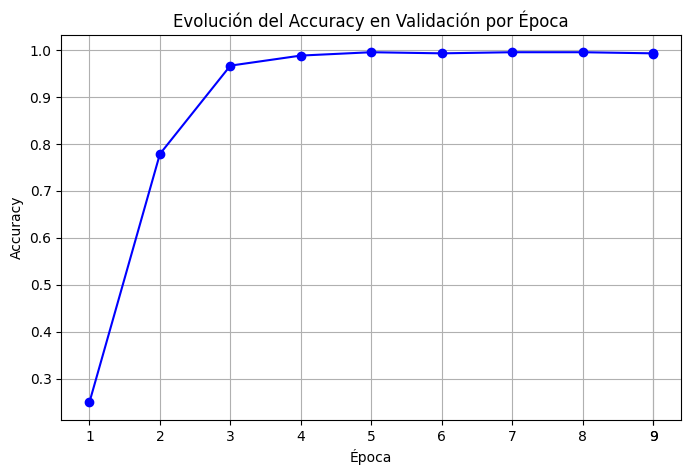

<Figure size 640x480 with 0 Axes>

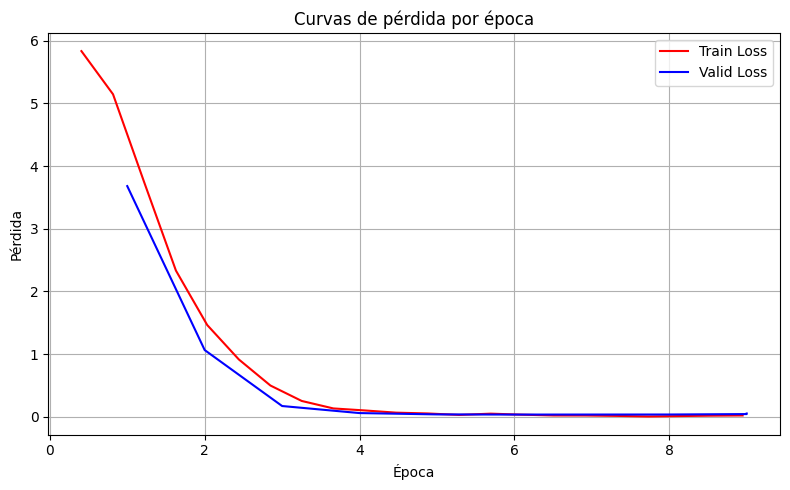

<ipython-input-28-55916c968b07>:118: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna_viz.plot_optimization_history(study)
[W 2025-06-06 11:19:32,040] There are no complete trials.


Métricas guardadas en /content/drive/MyDrive/TFG/models/finetuned_bert-base-uncased_loss/metrics_loss.json


/usr/local/lib/python3.11/dist-packages/optuna/visualization/matplotlib/_optimization_history.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")


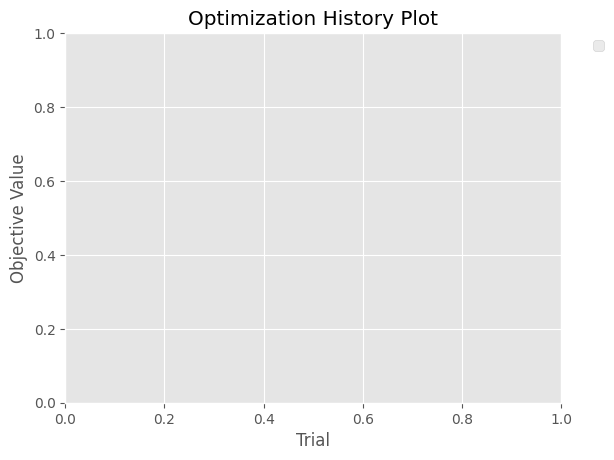

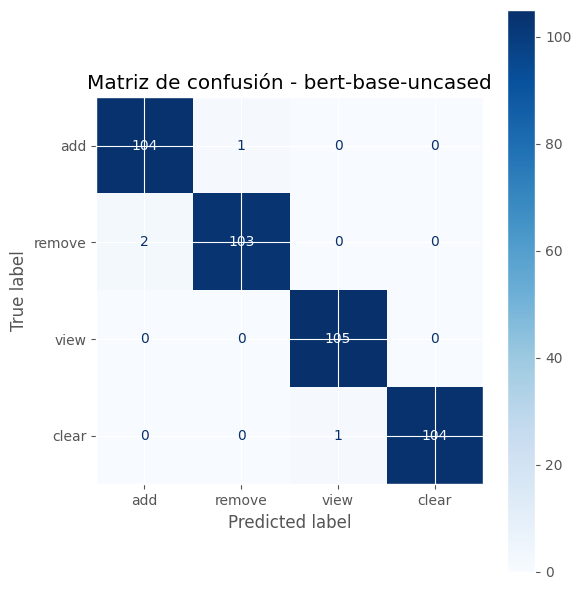

Modelo guardado en /content/drive/MyDrive/TFG/models/finetuned_bert-base-uncased_loss


In [ ]:
# Load the best configuration found by Optuna
params_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/{model_name.replace('/', '_')}_best_params_loss.json"
with open(params_path, "r") as f:
    best_params = json.load(f)

print("✅ Best hyperparameters:", best_params)

# Train the model with the best hyperparameters found
best_training_args = TrainingArguments(
    output_dir="results_bert",  # 📁 Folder where models and logs will be saved
    num_train_epochs=10,  # 🔁 Total number of full passes through the dataset
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    warmup_ratio=best_params["warmup_ratio"],
    weight_decay=best_params["weight_decay"],
    learning_rate=best_params["learning_rate"],
    eval_strategy="epoch",  # 📊 Evaluate once per epoch
    save_strategy="epoch",  # 💾 Save model at the end of each epoch
    save_total_limit=2,  # 📦 Keep only the last 2 models (saves space)
    load_best_model_at_end=True,  # 🏅 Load best model (based on validation) at the end
    metric_for_best_model="eval_loss",  # 🎯 Metric used to determine the best model
    greater_is_better=False,  # ✅ Lower is better (for loss)
    gradient_accumulation_steps=2,  # 🪄 Accumulate gradients to simulate larger batch size
    fp16=True,  # ⚡ Use 16-bit precision training (faster, uses less memory)
    logging_dir=f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/logs",  # 📝 Folder for training logs
    logging_steps=50,  # 📈 Log metrics every 50 steps
    lr_scheduler_type="cosine",  # 📉 Reduce learning rate following a cosine curve
    max_grad_norm=1.0  # 🚫 Gradient norm clipping to prevent exploding gradients
)

# Create a new Trainer with the best hyperparameters
best_trainer = Trainer(
    model_init=model_init,  # 🔧 Function to initialize the model (define externally)
    args=best_training_args,  # ⚙️ Training arguments defined above
    train_dataset=train_tokenized,  # 📚 Tokenized training dataset
    eval_dataset=valid_tokenized,  # 📚 Tokenized validation dataset
    tokenizer=tokenizer,  # ✂️ Tokenizer to convert text into token IDs
    compute_metrics=compute_metrics,  # 📏 Function to compute evaluation metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # 🛑 Stop if no improvement after 3 epochs
)

# Retrain the model using the best hyperparameters
best_trainer.train()

# Evaluate the optimized model
test_results = best_trainer.evaluate(test_tokenized)
print(f"📊 Test results: {test_results}")

# Access the training log history
log_history = best_trainer.state.log_history

# Filter logs that contain 'eval_accuracy'
accuracy_logs = [entry for entry in log_history if "eval_accuracy" in entry]

# Extract epochs and accuracies
epochs = [entry["epoch"] for entry in accuracy_logs]
accuracies = [entry["eval_accuracy"] for entry in accuracy_logs]

# Plot validation accuracy over epochs
plt.figure(figsize=(8,5))
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='b')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.grid(True)
plt.show()
plt.savefig(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/{model_name.replace('/', '_')}_accuracy_epochs_plot.png")

# Separate training and validation loss logs
train_logs = [e for e in log_history if "loss" in e and "eval_loss" not in e and "epoch" in e]
eval_logs  = [e for e in log_history if "eval_loss" in e]

df_train = pd.DataFrame(train_logs)
df_eval  = pd.DataFrame(eval_logs)

plt.figure(figsize=(8,5))

# Training loss curve (averaged by epoch)
if not df_train.empty:
    train_loss_by_epoch = df_train.groupby("epoch")["loss"].mean()
    plt.plot(train_loss_by_epoch.index, train_loss_by_epoch.values, label="Train Loss", color="red")

# Validation loss curve
if not df_eval.empty:
    plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Valid Loss", color="blue")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/loss_curves_{model_name.replace('/', '_')}.png")
plt.show()

# Save metrics to JSON
metrics_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/metrics_loss.json"
with open(metrics_path, "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Metrics saved to {metrics_path}")

# 📈 Optuna optimization history plot
fig = optuna_viz.plot_optimization_history(study)
fig_to_save = fig.figure
fig_to_save.savefig(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/optuna_history_loss.png")
plt.show()

# Confusion Matrix
# Get predictions and true labels from the test set
predictions_output = best_trainer.predict(test_tokenized)
all_preds_indices = np.argmax(predictions_output.predictions, axis=1)
all_labels_indices = test_tokenized["labels"]

# Convert numerical labels back to text labels using the label encoder
all_labels = label_encoder.inverse_transform(all_labels_indices)
all_preds = label_encoder.inverse_transform(all_preds_indices)

cm = confusion_matrix(all_labels, all_preds, labels=['add', 'remove', 'view', 'clear'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['add', 'remove', 'view', 'clear'])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {model_name}")
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}/confusion_matrix_{model_name.replace('/', '_')}_loss.png")
plt.show()

# Save the model and tokenizer
model_path = f"/content/drive/MyDrive/TFG/models/finetuned_{model_name.replace('/', '_')}"
best_trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model saved to {model_path}")
